### Loading modules and data

In [ ]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

# Scaling
from sklearn.preprocessing import RobustScaler

# Train Test Split
from sklearn.model_selection import train_test_split

# Models
import torch
import torch.nn as nn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import accuracy_score

In [ ]:
df = pd.read_csv("data/heart.csv")
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Preprocessing data

### Detecting and dealing with outliers

#### Detect outliers

In [ ]:
from scipy import stats
import numpy as np

def present_outliers(arr):
    vals, freq = np.unique(arr[0], return_counts=True)
    print(vals, freq)
    counts = {cols[i[0]]:i[1] for i in zip(vals, freq)}
    row_ind = np.unique(arr[1])
    print("Outlier count: ", counts)
    print("Outlier row indices: ", row_ind)

# IQR
def detect_outliers_iqr(df, cols):
    Q1 = np.array([np.percentile(df[cat], 25, interpolation = 'midpoint') for cat in cols])
    Q3 = np.array([np.percentile(df[cat], 75, interpolation = 'midpoint') for cat in cols])
    IQR = Q3 - Q1
    u = Q3 + 1.5*IQR
    l = Q1 - 1.5*IQR
    upper = np.asarray(df[cols] >= (Q3+1.5*IQR)).nonzero()
    # print("Upper bound:",upper)
    lower = np.asarray(df[cols] <= (Q1-1.5*IQR)).nonzero()
    # print("Lower bound:", lower)
    outliers = np.concatenate((lower, upper), axis=1)
    outliers[[0,1]] = outliers[[1,0]]
    return outliers

# Z score
def detect_outliers_z(df, cols, thresh=3):
    z = np.array([abs(stats.zscore(df[cat])) for cat in cols])
    outliers = np.asarray(z>thresh).nonzero()
    return outliers

In [ ]:
cols = ['age', 'trtbps', 'chol', 'thalachh', 'oldpeak']
outliers_z = detect_outliers_z(df, cols)
print(outliers_z)
present_outliers(outliers_z)

(array([1, 1, 2, 2, 2, 2, 3, 4, 4]), array([223, 248,  28,  85, 220, 246, 272, 204, 221]))
[1 2 3 4] [2 4 1 2]
Outlier count:  {'trtbps': 2, 'chol': 4, 'thalachh': 1, 'oldpeak': 2}
Outlier row indices:  [ 28  85 204 220 221 223 246 248 272]


In [ ]:
outliers_iqr = detect_outliers_iqr(df, cols)
print(outliers_iqr)
present_outliers(outliers_iqr)

[[  3   1   2   2   2   1   4   1   1   1   1   4   2   4   4   1   4   1
    1   2   1   4   1   1   4   1   4]
 [272   8  28  85  96 101 101 110 152 195 203 204 220 220 221 223 223 228
  241 246 248 250 260 266 291 292 295]]
[1 2 3 4] [13  5  1  8]
Outlier count:  {'trtbps': 13, 'chol': 5, 'thalachh': 1, 'oldpeak': 8}
Outlier row indices:  [  8  28  85  96 101 110 152 195 203 204 220 221 223 228 241 246 248 250
 260 266 272 291 292 295]


#### Remove outliers

In [ ]:
# Remove outliers

# mask_iqr = np.ones(len(df), dtype=bool)
# mask_iqr[outliers_iqr[1]] = False
# data_clean_iqr = df[mask_iqr]

# mask_z = np.ones(len(df), dtype=bool)
# mask_z[outliers_z[1]] = False
# data_clean_z = df[mask_z]
# print(data_clean_iqr.shape, df.shape, data_clean_z.shape)

#### Log-transform

In [ ]:
from itertools import chain, combinations

def powerset(iterable):
    "list(powerset([1,2,3])) --> [(), (1,), (2,), (3,), (1,2), (1,3), (2,3), (1,2,3)]"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def optimize_log_transform(df, cols):
    """
    Find categories whose transformation minimizes the number of outliers
    """
    col_powerset = powerset(cols)
    min_count = np.inf
    log_transform_cols = []
    for col_perm in col_powerset:
        col_perm = list(col_perm)
        data_clean_log = pd.DataFrame.copy(df)
        # data_clean_log = df
        data_clean_log[col_perm] = np.log(data_clean_log[col_perm])
        count_outliers = len(np.unique(detect_outliers_iqr(data_clean_log, cols)))
        # print(min_count, count_outliers, col_perm)
        if count_outliers < min_count:
            min_count = count_outliers
            log_transform_cols = col_perm
    return (min_count, log_transform_cols)

### Other

In [ ]:
# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

def process_data(df, cat_cols, con_cols):
  # encoding the categorical columns
  df = pd.get_dummies(df, columns = cat_cols, drop_first = True)
  # defining the features and target
  X = df.drop(['output'],axis=1)
  y = df[['output']]
  # instantiating the scaler
  scaler = RobustScaler()
  # scaling the continuous featuree
  X[con_cols] = scaler.fit_transform(X[con_cols])
  return X, y

Number of zero values by feature
age          0
trtbps       0
chol         0
thalachh     0
oldpeak     99
dtype: int64


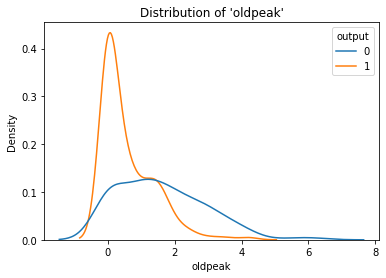

In [ ]:
# untransformed data
df_base = pd.DataFrame.copy(df)
X, y = process_data(df_base, cat_cols, con_cols)

print("Number of zero values by feature")
print((df[df==0]).count()[con_cols])
con_cols_pos = [x for x in con_cols if x!="oldpeak"] # transform only columns with positive values
import seaborn as sns
sns.kdeplot(data=df, x="oldpeak", hue="output")
plt.title("Distribution of 'oldpeak'")

# log-transform data before processing
df_log = pd.DataFrame.copy(df)
# transform cols that minimize outlier count
min_outlier_count, log_transform_cols = optimize_log_transform(df_log, con_cols_pos)
df_log[log_transform_cols] = np.log(df_log[log_transform_cols])
X_log, y_log = process_data(df_log, cat_cols, con_cols)

df_log1 = pd.DataFrame.copy(df)
# transform all cols
df_log1[con_cols_pos] = np.log(df_log1[con_cols_pos])
X_log1, y_log1 = process_data(df_log1, cat_cols, con_cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)
X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log,y_log, test_size = 0.2, random_state = 42)
X_log1_train, X_log1_test, y_log1_train, y_log1_test = train_test_split(X_log1, y_log1, test_size = 0.2, random_state = 42)

## Models

### SVM

##### Custom

In [ ]:
class SVM_():

    def __init__(self, learning_rate=0.1, max_iter=1000, C = 0.1, tolerance = 1e-4):
        self.learning_rate  = learning_rate
        self.max_iter       = max_iter
        self.C              = C
        self.tolerance      = tolerance
    
    def fit(self, X, y, verbose=False):

        self.theta = np.zeros(X.shape[1] + 1)
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = y.to_numpy()

        for i in range(self.max_iter):
            dists = 1 - (y.T*(X @ self.theta)).T
            N = X.shape[1]
            # print(res.shape, X.shape, y.shape, dists.shape, self.theta.shape, (y.T*(X @ self.theta)).shape)
            delta_grad = np.where(dists>0, self.theta-self.C*y*X, self.theta).sum(axis=0)
            # print(delta_grad.shape)
            if np.all(abs(delta_grad) >= self.tolerance):
                self.theta -= self.learning_rate/N * delta_grad
                if verbose:
                    print(i, self.cost(X[:, 1:], y))
            else:
                break
                
        return self

    def predict(self, X):
        return np.sign(X @ self.theta[1:] + self.theta[0])

    def cost(self, X, y):
        dists = 1 - (y.T*(X @ self.theta[1:] + self.theta[0])).T
        dists[dists<0] = 0
        return 1/2 * np.dot(self.theta, self.theta) + self.C/X.shape[0] * dists.sum()


In [ ]:
c_values = np.logspace(-3, 1, 100)
# c_values = [0.37]
# learning_rate = np.logspace(0.001, 1, 50)
learning_rate = [0.01]
for c in c_values:
        for lr in learning_rate:
            svm = SVM_(C=c, learning_rate=lr, max_iter=10000)
            svm.fit(X_train, y_train)
            y_pred = svm.predict(X_test)
            print(c, lr, accuracy_score(y_test, y_pred))

0.001 0.01 0.5245901639344263
0.0010974987654930556 0.01 0.5245901639344263
0.0012045035402587824 0.01 0.5245901639344263
0.0013219411484660286 0.01 0.5245901639344263
0.0014508287784959402 0.01 0.5245901639344263
0.0015922827933410922 0.01 0.5245901639344263
0.001747528400007683 0.01 0.5245901639344263
0.0019179102616724887 0.01 0.5245901639344263
0.00210490414451202 0.01 0.5245901639344263
0.0023101297000831605 0.01 0.5245901639344263
0.0025353644939701114 0.01 0.5245901639344263
0.0027825594022071257 0.01 0.5245901639344263
0.0030538555088334154 0.01 0.5245901639344263
0.003351602650938841 0.01 0.5245901639344263
0.0036783797718286343 0.01 0.5245901639344263
0.004037017258596553 0.01 0.5245901639344263
0.004430621457583882 0.01 0.5245901639344263
0.004862601580065354 0.01 0.5245901639344263
0.005336699231206312 0.01 0.5245901639344263
0.005857020818056668 0.01 0.5245901639344263
0.006428073117284319 0.01 0.5245901639344263
0.007054802310718645 0.01 0.5245901639344263
0.0077426368268

##### Sklearn

In [ ]:
for k in ['linear']:
  # for c in np.linspace(0.360, 0.404, 30):
  for c in [0.38]:
    clf = SVC(kernel=k, C=c, random_state=42).fit(X_train,np.ravel(y_train))
    y_pred = clf.predict(X_test)
    print(f"The test accuracy score of SVM ({k}) is ", accuracy_score(y_test, y_pred))
for k in ['rbf']:
  # for c in np.linspace(1.41, 1.645, 40):
  # for c in np.linspace(0.0001,10, 50):
  for c in [1.5]:
   for (Xtr, Xte, ytr, yte) in [
       (X_train, X_test, y_train, y_test),
       (X_log_train, X_log_test, y_log_train, y_log_test),
       (X_log1_train, X_log1_test, y_log1_train, y_log1_test)
    ]:
    clf = SVC(kernel=k, C=c, random_state=42).fit(Xtr,np.ravel(ytr))
    y_pred = clf.predict(Xte)
    print(f"The test accuracy score of SVM ({k}) is ", accuracy_score(yte, y_pred))
for k in ['sigmoid']:
  # for c in np.linspace(0.97, 0.95, 100):
  for c in [0.96]:
    clf = SVC(kernel=k, C=c, random_state=42).fit(X_train,np.ravel(y_train))
    y_pred = clf.predict(X_test)
    print(f"The test accuracy score of SVM ({k}) is ", accuracy_score(y_test, y_pred))

The test accuracy score of SVM (linear) is  0.8852459016393442
The test accuracy score of SVM (rbf) is  0.9016393442622951
The test accuracy score of SVM (rbf) is  0.9016393442622951
The test accuracy score of SVM (rbf) is  0.8852459016393442
The test accuracy score of SVM (sigmoid) is  0.8688524590163934


### Logistic regression

##### Pytorch

In [ ]:
class TorchLogisticRegression(torch.nn.Module):
    def __init__(self,no_input_features):
        super(TorchLogisticRegression,self).__init__()
        self.layer=torch.nn.Linear(no_input_features,1)

    def forward(self,x):
        y_predicted=torch.sigmoid(self.layer(x))
        return y_predicted

def torch_fit_predict(x_train, x_test, y_train, y_test, lr=0.01, max_iter=10000, C=0, verbose=False):
    n_samples,n_features=X.shape
    torch_logreg = TorchLogisticRegression(n_features)
    criterion=torch.nn.BCELoss()                                # loss function
    optimizer=torch.optim.SGD(torch_logreg.parameters(), lr=lr, weight_decay=C) # gradient descent

    for epoch in range(max_iter):
        y_pred=torch_logreg(x_train)
        loss=criterion(y_pred,y_train)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if verbose:
            print('epoch:', epoch+1,', loss: ', loss.item())

    with torch.no_grad():
        y_pred = torch_logreg(x_test).round()
        print(
            "The test accuracy score of a Pytorch Logistic Regression is: ", 
            accuracy_score(y_test, y_pred)
            )

In [ ]:
x_train_torch=torch.tensor(X_train.values).float()
x_test_torch=torch.tensor(X_test.values).float()
y_train_torch=torch.tensor(y_train.values).view(y_train.shape[0],1).float()
y_test_torch=torch.tensor(y_test.values).view(y_test.shape[0],1).float()

for c in np.logspace(0.1, 10, 10):
    torch_fit_predict(x_train_torch, x_test_torch, y_train_torch, y_test_torch)

The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.8852459016393442
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.8852459016393442
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951
The test accuracy score of a Pytorch Logistic Regression is:  0.9016393442622951


##### Custom

In [ ]:
class LogisticRegression_():

    def __init__(self, learning_rate=0.1, max_iter=100, regularization='l2', C = 0.1, tolerance = 1e-4):
        self.learning_rate  = learning_rate
        self.max_iter       = max_iter
        self.regularization = regularization
        self.C              = C
        self.tolerance      = tolerance
    
    def fit(self, X, y, verbose=False):

        self.theta = np.zeros(X.shape[1] + 1)
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = y.to_numpy()
        for i in range(self.max_iter):
        
            errors = (self.__sigmoid(X @ self.theta)) - y
            N = X.shape[1]

            if self.regularization == 'l2':
                delta_grad = np.sum((X.T @ errors).T, axis=0) + self.C*self.theta
                # print((X.T @ errors).shape)
            else:
                delta_grad = np.sum((X.T @ errors).T, axis=0)

            if np.all(abs(delta_grad) >= self.tolerance):
                self.theta -= self.learning_rate/N * delta_grad
                if verbose:
                    print(i, self.cost(X[:, 1:], y))
            else:
                break
                
        return self

    def predict(self, X):
        return np.round(self.__sigmoid((X @ self.theta[1:]) + self.theta[0]))
        
    def __sigmoid(self, X):
        return 1/2 * (1 + np.tanh(1/2 * X))
    
    def cost(self, X, y):
        m = X.shape[1]
        h = self.__sigmoid(X @ self.theta[1:] + self.theta[0])
        epsilon = 1e-5
        return -(1/m)* (y.T @ np.log(h + epsilon)+(1-y).T @ np.log(1-h + epsilon)
         + 1/2*self.C * np.dot(self.theta[1:], self.theta[1:]))


In [ ]:
solvers = ['liblinear']
penalty = ['l2']
# c_values = np.linspace(0.001, 10, 10)
c_values = [1.0]
# learning_rate = np.linspace(0.001, 0.1, 4)
learning_rate = [0.01]
for p in penalty:
    for c in c_values:
        for lr in learning_rate:
            logreg = LogisticRegression_(regularization=p, C=c, learning_rate=lr, max_iter=1000)
            logreg.fit(X_train, y_train)
            y_pred = logreg.predict(X_test)
            print("The test accuracy score of a custom Logistic Regression is: ", accuracy_score(y_test, y_pred))

The test accuracy score of a custom Logistic Regression is:  0.8524590163934426


##### Sklearn

In [ ]:
# solvers = ['liblinear']
penalty = ['l1', 'l2', 'none']
c_values = [100, 10, 1.0, 0.1, 0.01]

# check different hyperparameter values
for p in penalty:
    for c in c_values:
        logreg = LogisticRegression()
        logreg.fit(X_train, np.ravel(y_train))
        y_pred_proba = logreg.predict_proba(X_test)
        y_pred = np.argmax(y_pred_proba,axis=1)
        print("The test accuracy score of Logistric Regression is ", accuracy_score(y_test, y_pred))

# fitting log-transformed data (all columns)
logreg.fit(X_log_train, np.ravel(y_log_train))
y_log_pred_proba = logreg.predict_proba(X_log_test)
y_log_pred = np.argmax(y_log_pred_proba,axis=1)
print("The test accuracy score of Logistric Regression is ", accuracy_score(y_log_test, y_log_pred))

# fitting log-transformed data (selected columns)
logreg.fit(X_log1_train, np.ravel(y_log1_train))
y_log1_pred_proba = logreg.predict_proba(X_log1_test)
y_log1_pred = np.argmax(y_log1_pred_proba,axis=1)
print("The test accuracy score of Logistric Regression is ", accuracy_score(y_log1_test, y_log1_pred))

The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The test accuracy score of Logistric Regression is  0.9016393442622951
The te

### Conclusions

TODO